In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import os

_current_fname = Path(locals()["__vsc_ipynb_file__"])
os.chdir(_current_fname.parent)

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [4]:
os.chdir(
    "/hpc/mydata/saugat.kandel/sam2_projects/segment-anything-2/notebooks/cryosam_results_analysis"
)

In [5]:
import sys

sys.path.append("../")
import my_sam2_utils as utils
import stats_utils as stats

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import copick
from tqdm.notebook import tqdm
import joblib
import skimage
import cupy
import cucim.skimage as cskimage

In [7]:
copick_config = (
    "/hpc/projects/group.czii/krios1.processing/copick/24jul29c/run002/copick_config.json"
)
name = "lysosome"

# Open Copick Project and Query All Available Runs
root = copick.from_file(copick_config)
run_ids = [run.name for run in root.runs]

In [8]:
runs_with_lysosomes = []
coords_per_run = {}
for run in root.runs:
    coords = utils.get_coordinates(run)
    if coords is None or not utils.check_tomogram(run):
        continue
    runs_with_lysosomes.append(run)
    coords_per_run[run.name] = coords

In [9]:
len(runs_with_lysosomes)

144

### only for Daniel's picks.


In [10]:
recalculate_daniel_picks = True
input_dir = Path("../cryosam_daniel_study18_outputs")

if recalculate_daniel_picks:
    daniel_picks_results, auto_masks, (tps, fps, fns) = stats.calculate_statistics_for_daniel_picks(
        runs_with_lysosomes, coords_per_run, non_copick_input_dir=input_dir
    )
    results_to_store = (daniel_picks_results, auto_masks, (tps, fps, fns))
    joblib.dump(results_to_store, input_dir / "daniel_picks_analysis.pkl")
else:
    daniel_picks_results, auto_masks, (tps, fps, fns) = joblib.load(
        input_dir / "daniel_picks_analysis.pkl"
    )

  0%|          | 0/144 [00:00<?, ?it/s]

In [11]:
tps_total = np.sum(list(tps.values()))
fps_total = np.sum(list(fps.values()))
fns_total = np.sum(list(fns.values()))
print(f"TPs: {tps_total}, FPs: {fps_total}, FNs: {fns_total}")

TPs: 163, FPs: 206, FNs: 49


In [12]:
n_runs = 0
n_picks = 0
n_overlaps = 0
runs_skipped = []
for run in runs_with_lysosomes:
    run_name = run.name
    outs = auto_masks[run_name]
    if outs is None:
        print(f"Skipping {run_name} since it has no daniel picks.")
        runs_skipped.append(run)
        continue
    n_overlaps += 1 if outs["flags"]["overlap"] else 0
    n_runs += 1
    if len(daniel_picks_results[run_name]) == 0:
        print(len(outs["masks"]))

    n_picks += len(daniel_picks_results[run_name])

Skipping Position_24_4_Vol since it has no daniel picks.
2
1
2
Skipping Position_38_2_Vol since it has no daniel picks.
3
1
Skipping Position_41_Vol since it has no daniel picks.
Skipping Position_42_2_Vol since it has no daniel picks.
1
Skipping Position_45_7_Vol since it has no daniel picks.
Skipping Position_47_Vol since it has no daniel picks.
Skipping Position_4_2_Vol since it has no daniel picks.
1
2
2


In [13]:
n_runs, n_picks, n_overlaps

(137, 163, 0)

Position_42_2_Vol
Getting denoised Tomogram with 10 A voxel size for the associated runID: Position_42_2_Vol


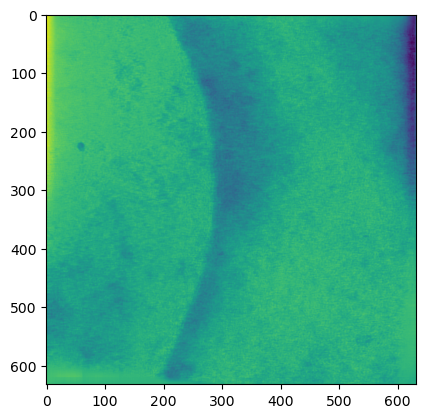

In [14]:
_idx = 3
print(runs_skipped[_idx].name)
plt.imshow(utils.get_tomogram(runs_skipped[_idx]).sum(axis=0))

In [15]:
auto_masks["Position_23_Vol"]

{'masks': [{'segmentation': array([[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          ...,
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False]]),
   'area': 33115,
   'bbox': [118.0, 199.0, 230.0, 231.0],
   'predicted_iou': 0.94921875,
   'point_coords': [[325.875, 365.375]],
   'stability_score': 0.9609712958335876,
   'crop_box': [0.0, 0.0, 632.0, 632.0]}],
 'flags': {'overlap': False}}

In [25]:
axmaj_all = []
for run, picks in daniel_picks_results.items():
    for pick in picks:
        axmaj_all.append(pick["axmaj"])
axmaj_all = np.array(axmaj_all)

axmin_all = []
for run, picks in daniel_picks_results.items():
    for pick in picks:
        axmin_all.append(pick["axmin"])
axmin_all = np.array(axmin_all)

diam_all = (axmaj_all + axmin_all) / 2
ratio_all = axmaj_all / axmin_all

In [26]:
ratio_all.max(), diam_all.max()

(np.float64(4.519157798281305), np.float64(502.0922447336593))

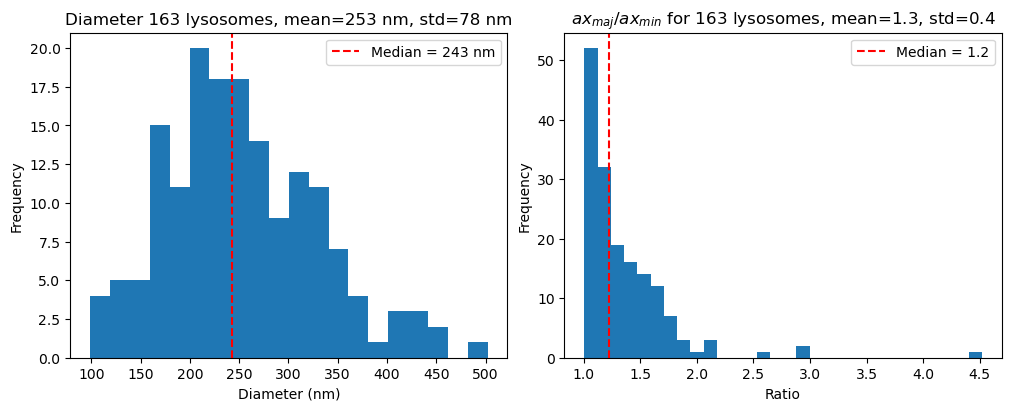

In [27]:
plt.figure(figsize=(10, 4), constrained_layout=True)

plt.subplot(1, 2, 1)
plt.hist(diam_all, bins=20)
plt.xlabel("Diameter (nm)")
plt.ylabel("Frequency")
plt.title(
    f"Diameter {len(diam_all)} lysosomes, mean={diam_all.mean():.0f} nm, std={diam_all.std():.0f} nm"
)
plt.axvline(
    np.median(diam_all), color="r", linestyle="--", label=f"Median = {np.median(diam_all):.0f} nm"
)
plt.legend()

plt.subplot(1, 2, 2)


plt.subplot(1, 2, 2)
plt.hist(ratio_all, bins=30)
plt.xlabel("Ratio")
plt.ylabel("Frequency")
plt.title(
    rf"$ax_{{maj}}/ ax_{{min}}$ for {len(diam_all)} lysosomes, mean={ratio_all.mean():.1f}, std={ratio_all.std():.1f}"
)
plt.axvline(
    np.median(ratio_all), color="r", linestyle="--", label=f"Median = {np.median(ratio_all):.1f}"
)
plt.legend()


# plt.savefig("diam_ratio_24jul29c.svg", bbox_inches="tight")
plt.show()

Text(0.5, 0.98, "Difference between SAM2 centroids and Daniel's picks")

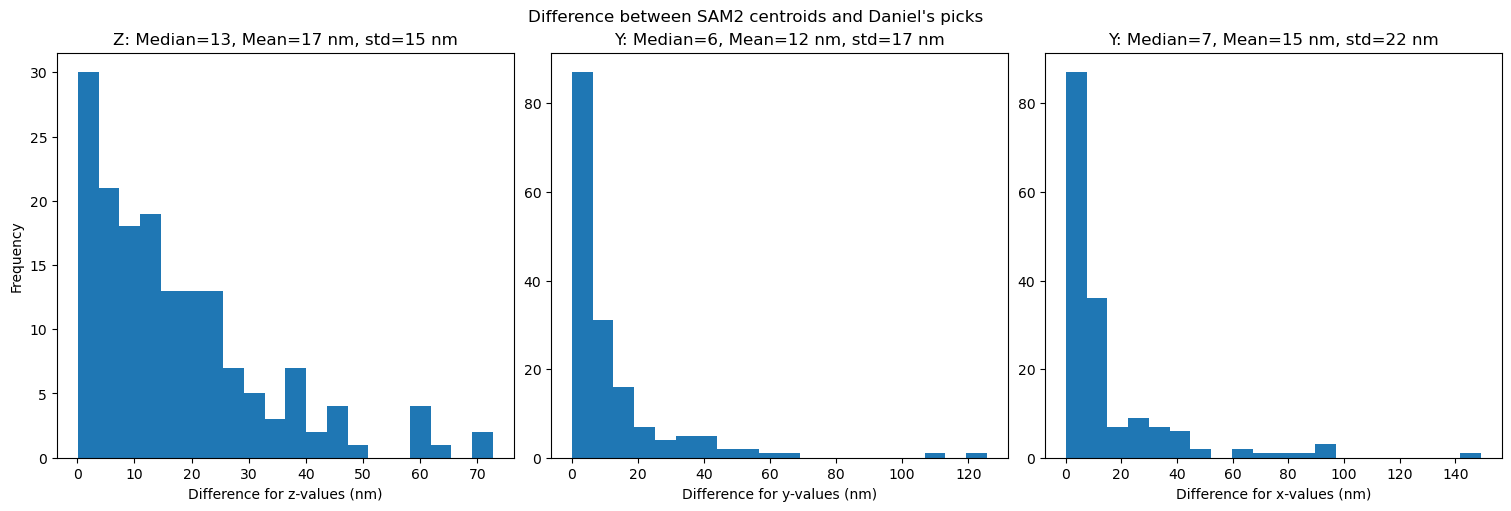

In [28]:
centroid_all = []
for run, picks in daniel_picks_results.items():
    for pick in picks:
        centroid_all.append(pick["sam2_centroid"])
centroid_all = np.array(centroid_all)

coords_all = []
for run, picks in daniel_picks_results.items():
    for pick in picks:
        coords_all.append(pick["coord"])
coords_all = np.array(coords_all)

differences_abs = np.abs(centroid_all - coords_all)

fig, axs = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)
axs[0].hist(differences_abs[:, 0], bins=20)
axs[0].set_xlabel("Difference for z-values (nm)")
axs[0].set_ylabel("Frequency")
axs[0].set_title(
    f"Z: Median={np.median(differences_abs[:, 0]):.0f}, Mean={differences_abs[:, 0].mean():.0f} nm, std={differences_abs[:, 0].std():.0f} nm"
)

axs[1].hist(differences_abs[:, 1], bins=20)
axs[1].set_xlabel("Difference for y-values (nm)")
axs[1].set_title(
    f"Y: Median={np.median(differences_abs[:, 1]):.0f}, Mean={differences_abs[:, 1].mean():.0f} nm, std={differences_abs[:, 1].std():.0f} nm"
)

axs[2].hist(differences_abs[:, 2], bins=20)
axs[2].set_xlabel("Difference for x-values (nm)")
axs[2].set_title(
    f"Y: Median={np.median(differences_abs[:, 2]):.0f}, Mean={differences_abs[:, 2].mean():.0f} nm, std={differences_abs[:, 2].std():.0f} nm"
)

plt.suptitle("Difference between SAM2 centroids and Daniel's picks")


### This is for all picks not just daniel's.


In [29]:
recalculate_picks = False
if recalculate_picks:
    results_all_picks, auto_masks_all = stats.calculate_statistics_for_all_picks(
        root.runs, non_copick_input_dir=input_dir
    )
    results_to_store = (results_all_picks, auto_masks_all)
    joblib.dump(results_to_store, input_dir / "all_picks_analysis.pkl")
else:
    results_all_picks, auto_masks_all = joblib.load(input_dir / "all_picks_analysis.pkl")

In [30]:
axmaj_all = []
for run, picks in results_all_picks.items():
    for pick in picks:
        axmaj_all.append(pick["axmaj"])
axmaj_all = np.array(axmaj_all)

axmin_all = []
for run, picks in results_all_picks.items():
    for pick in picks:
        axmin_all.append(pick["axmin"])
axmin_all = np.array(axmin_all)

diam_all = (axmaj_all + axmin_all) / 2
ratio_all = axmaj_all / axmin_all
ratio_all = ratio_all[~np.isnan(ratio_all)]

/tmp/ipykernel_3778234/2957354967.py:14: RuntimeWarning: invalid value encountered in divide
  ratio_all = axmaj_all / axmin_all


In [31]:
len(diam_all)

662

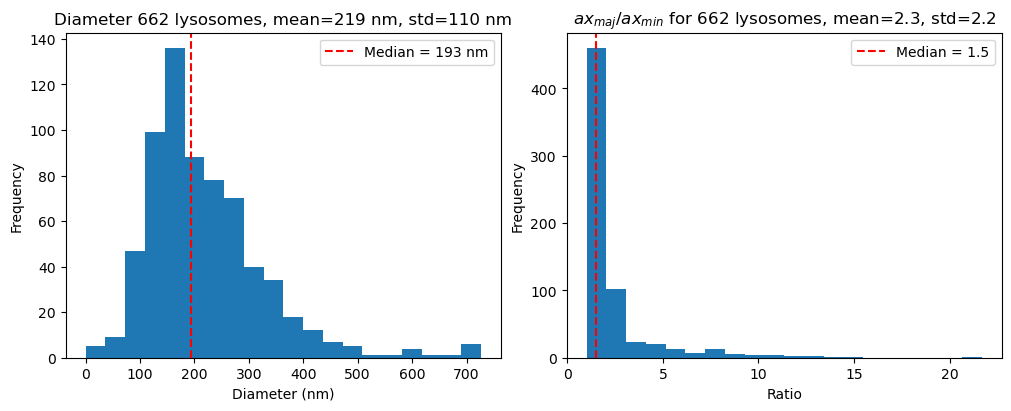

In [32]:
plt.figure(figsize=(10, 4), constrained_layout=True)

plt.subplot(1, 2, 1)
plt.hist(diam_all, bins=20)
plt.xlabel("Diameter (nm)")
plt.ylabel("Frequency")
plt.title(
    f"Diameter {len(diam_all)} lysosomes, mean={diam_all.mean():.0f} nm, std={diam_all.std():.0f} nm"
)
plt.axvline(
    np.median(diam_all), color="r", linestyle="--", label=f"Median = {np.median(diam_all):.0f} nm"
)
plt.legend()

plt.subplot(1, 2, 2)


plt.subplot(1, 2, 2)
plt.hist(ratio_all, bins=20)
plt.xlabel("Ratio")
plt.ylabel("Frequency")
plt.title(
    rf"$ax_{{maj}}/ ax_{{min}}$ for {len(diam_all)} lysosomes, mean={ratio_all.mean():.1f}, std={ratio_all.std():.1f}"
)
plt.axvline(
    np.median(ratio_all), color="r", linestyle="--", label=f"Median = {np.median(ratio_all):.1f}"
)
plt.legend()
plt.show()

### This is for all picks in the tomograms picked by Daniel.


In [33]:
recalculate_picks = True
if recalculate_picks:
    results_all_picks, auto_masks_all = stats.calculate_statistics_for_all_picks(
        runs_with_lysosomes, non_copick_input_dir=input_dir
    )
    results_to_store = (results_all_picks, auto_masks_all)
    joblib.dump(results_to_store, input_dir / "daniel_tomos_all_picks_analysis.pkl")
else:
    results_all_picks, auto_masks_all = joblib.load(
        input_dir / "daniel_tomos_all_picks_analysis.pkl"
    )

  0%|          | 0/144 [00:00<?, ?it/s]

Analyzing run: Position_11_2_Vol
Analyzing run: Position_11_5_Vol
Analyzing run: Position_12_2_Vol
Analyzing run: Position_12_3_Vol
Analyzing run: Position_12_4_Vol
Analyzing run: Position_12_Vol
Analyzing run: Position_13_3_Vol
Analyzing run: Position_13_4_Vol
Analyzing run: Position_13_5_Vol
Analyzing run: Position_13_6_Vol
Analyzing run: Position_13_Vol
Analyzing run: Position_14_2_Vol
Analyzing run: Position_14_4_Vol
Analyzing run: Position_14_Vol
Analyzing run: Position_15_3_Vol
Analyzing run: Position_15_Vol
Analyzing run: Position_16_2_Vol
Analyzing run: Position_16_Vol
Analyzing run: Position_17_3_Vol
Analyzing run: Position_18_Vol
Analyzing run: Position_19_2_Vol
Analyzing run: Position_19_3_Vol
Analyzing run: Position_19_4_Vol
Analyzing run: Position_19_5_Vol
Analyzing run: Position_1_3_Vol
Analyzing run: Position_20_2_Vol
Analyzing run: Position_20_3_Vol
Analyzing run: Position_20_4_Vol
Analyzing run: Position_20_5_Vol
Analyzing run: Position_21_2_Vol
Analyzing run: Position

In [34]:
axmaj_all = []
for run, picks in results_all_picks.items():
    for pick in picks:
        axmaj_all.append(pick["axmaj"])
axmaj_all = np.array(axmaj_all)

axmin_all = []
for run, picks in results_all_picks.items():
    for pick in picks:
        axmin_all.append(pick["axmin"])
axmin_all = np.array(axmin_all)

diam_all = (axmaj_all + axmin_all) / 2
ratio_all = axmaj_all / axmin_all
ratio_all = ratio_all[~np.isnan(ratio_all)]

/tmp/ipykernel_3778234/2957354967.py:14: RuntimeWarning: invalid value encountered in divide
  ratio_all = axmaj_all / axmin_all


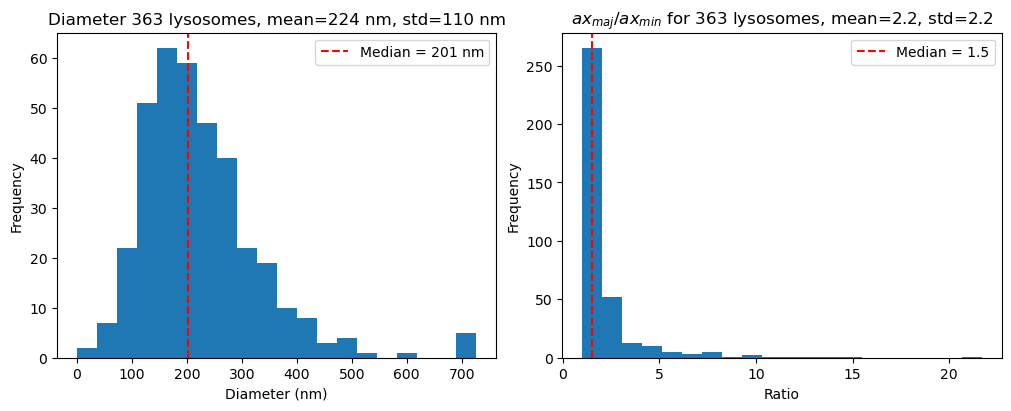

In [35]:
plt.figure(figsize=(10, 4), constrained_layout=True)

plt.subplot(1, 2, 1)
plt.hist(diam_all, bins=20)
plt.xlabel("Diameter (nm)")
plt.ylabel("Frequency")
plt.title(
    f"Diameter {len(diam_all)} lysosomes, mean={diam_all.mean():.0f} nm, std={diam_all.std():.0f} nm"
)
plt.axvline(
    np.median(diam_all), color="r", linestyle="--", label=f"Median = {np.median(diam_all):.0f} nm"
)
plt.legend()

plt.subplot(1, 2, 2)


plt.subplot(1, 2, 2)
plt.hist(ratio_all, bins=20)
plt.xlabel("Ratio")
plt.ylabel("Frequency")
plt.title(
    rf"$ax_{{maj}}/ ax_{{min}}$ for {len(diam_all)} lysosomes, mean={ratio_all.mean():.1f}, std={ratio_all.std():.1f}"
)
plt.axvline(
    np.median(ratio_all), color="r", linestyle="--", label=f"Median = {np.median(ratio_all):.1f}"
)
plt.legend()
plt.show()

### Analyzing picks not Daniel's


In [36]:
def _compare_picks(run, pick1):
    for pick2 in daniel_picks_results[run]:
        if np.linalg.norm(pick1["centroid"] - pick2["sam2_centroid"]) == 0:
            return True
    return False


false_pos_picks = {}
for run in results_all_picks:
    false_pos_picks[run] = []
    if run not in daniel_picks_results:
        false_pos_picks[run] = results_all_picks[run]
        continue
    for pick in results_all_picks[run]:
        if not _compare_picks(run, pick):
            false_pos_picks[run].append(pick)


In [37]:
axmaj_all = []
for run, picks in false_pos_picks.items():
    for pick in picks:
        axmaj_all.append(pick["axmaj"])
axmaj_all = np.array(axmaj_all)

axmin_all = []
for run, picks in false_pos_picks.items():
    for pick in picks:
        axmin_all.append(pick["axmin"])
axmin_all = np.array(axmin_all)

diam_all = (axmaj_all + axmin_all) / 2
ratio_all = axmaj_all / axmin_all
ratio_all = ratio_all[~np.isnan(ratio_all)]

/tmp/ipykernel_3778234/1021533978.py:14: RuntimeWarning: invalid value encountered in divide
  ratio_all = axmaj_all / axmin_all


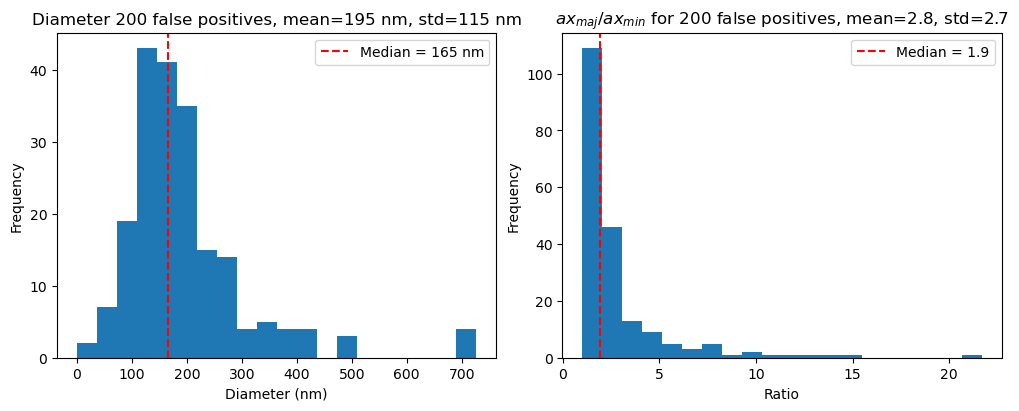

In [38]:
plt.figure(figsize=(10, 4), constrained_layout=True)

plt.subplot(1, 2, 1)
plt.hist(diam_all, bins=20)
plt.xlabel("Diameter (nm)")
plt.ylabel("Frequency")
plt.title(
    f"Diameter {len(diam_all)} false positives, mean={diam_all.mean():.0f} nm, std={diam_all.std():.0f} nm"
)
plt.axvline(
    np.median(diam_all), color="r", linestyle="--", label=f"Median = {np.median(diam_all):.0f} nm"
)
plt.legend()

plt.subplot(1, 2, 2)


plt.subplot(1, 2, 2)
plt.hist(ratio_all, bins=20)
plt.xlabel("Ratio")
plt.ylabel("Frequency")
plt.title(
    rf"$ax_{{maj}}/ ax_{{min}}$ for {len(diam_all)} false positives, mean={ratio_all.mean():.1f}, std={ratio_all.std():.1f}"
)
plt.axvline(
    np.median(ratio_all), color="r", linestyle="--", label=f"Median = {np.median(ratio_all):.1f}"
)
plt.legend()
plt.show()

In [39]:
### Visualizing only Daniel's picks

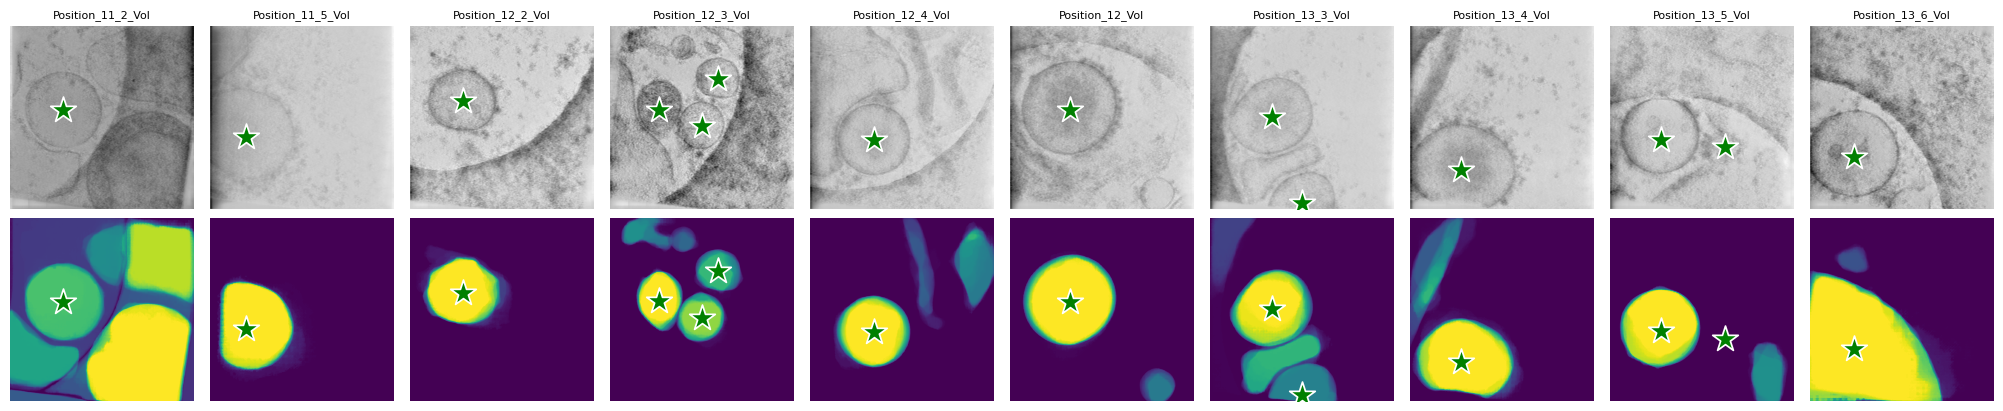

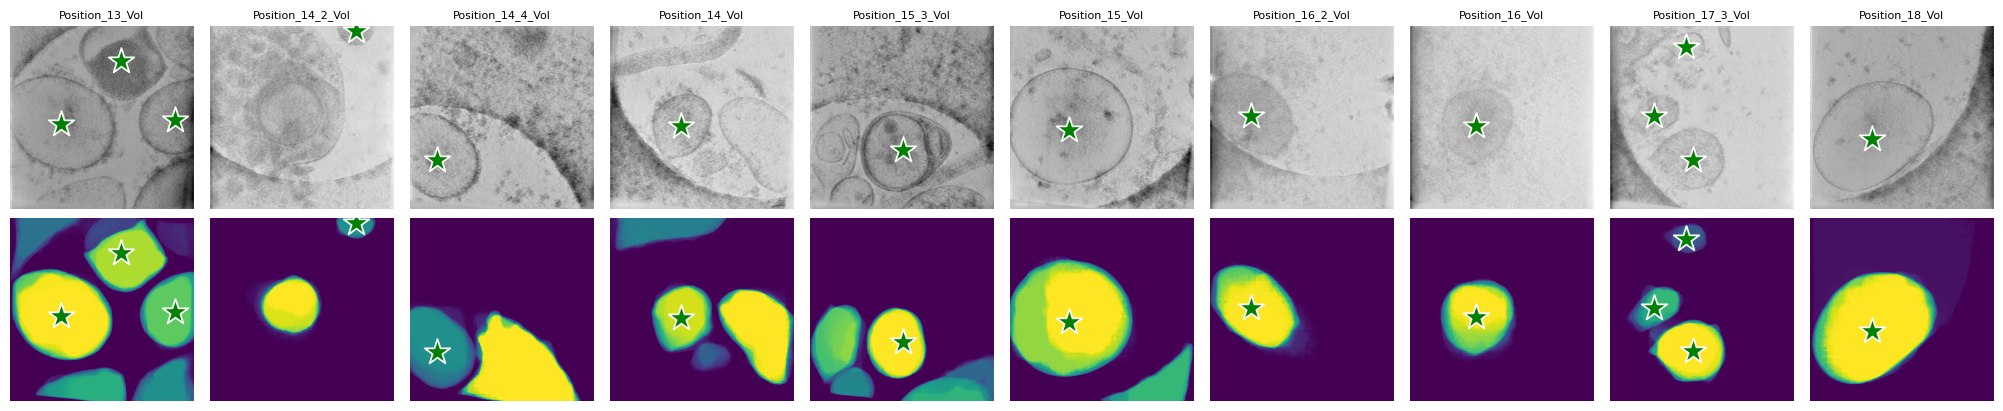

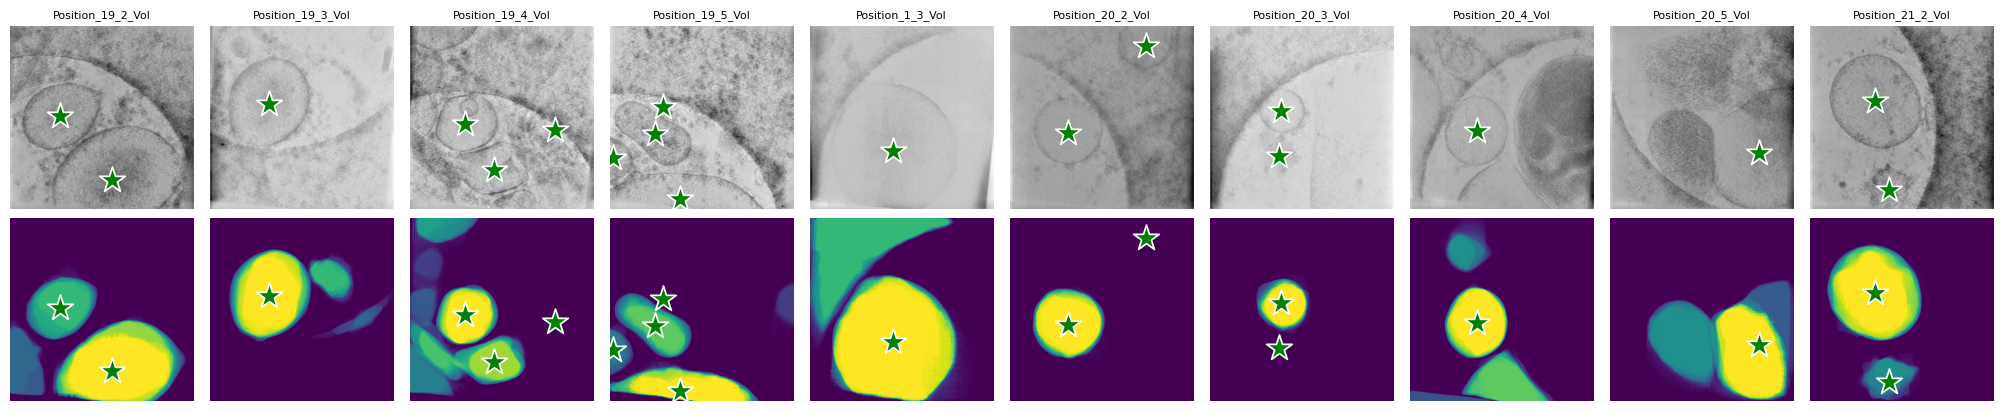

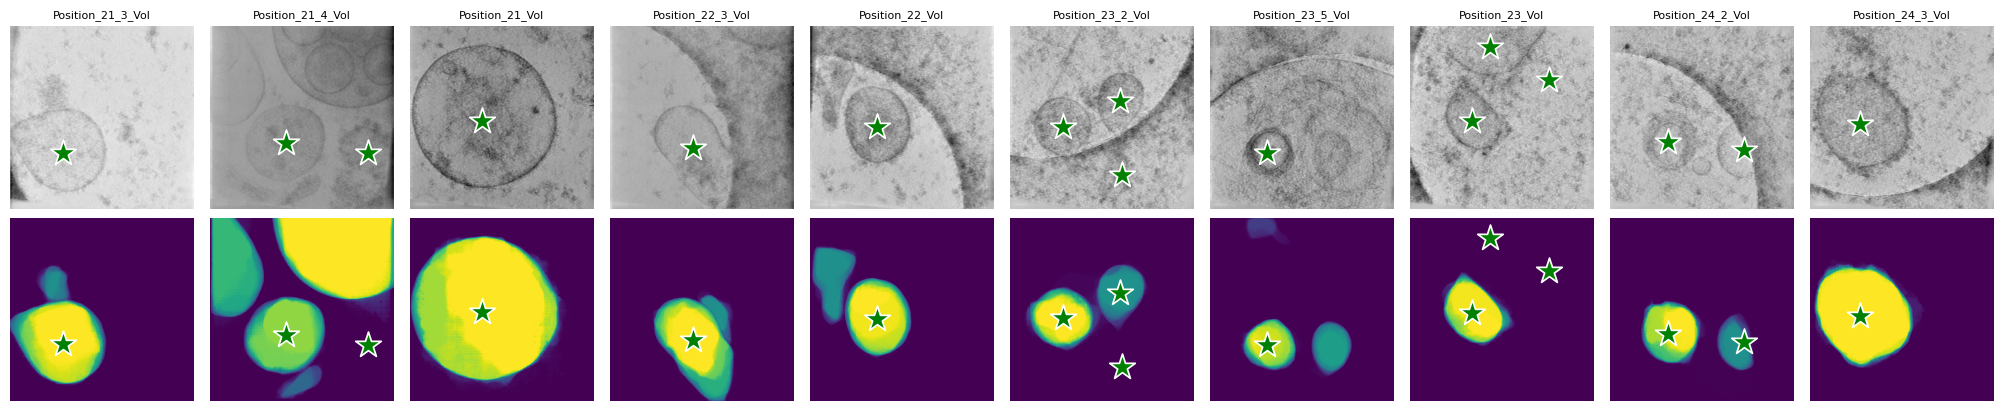

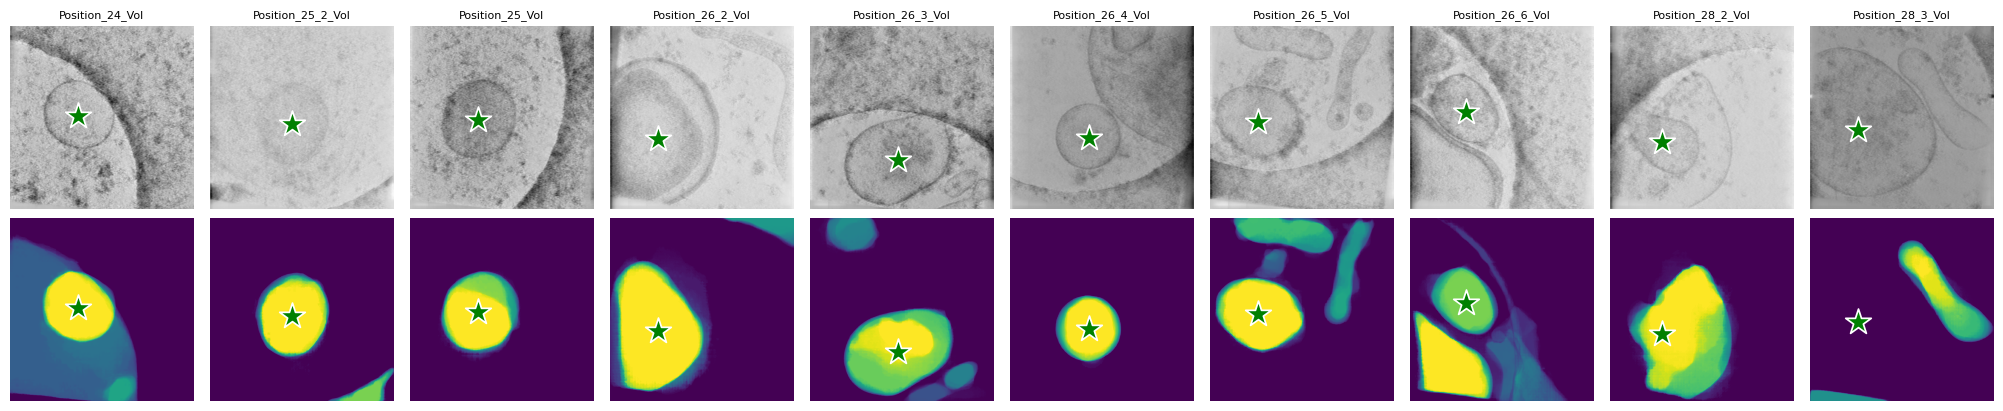

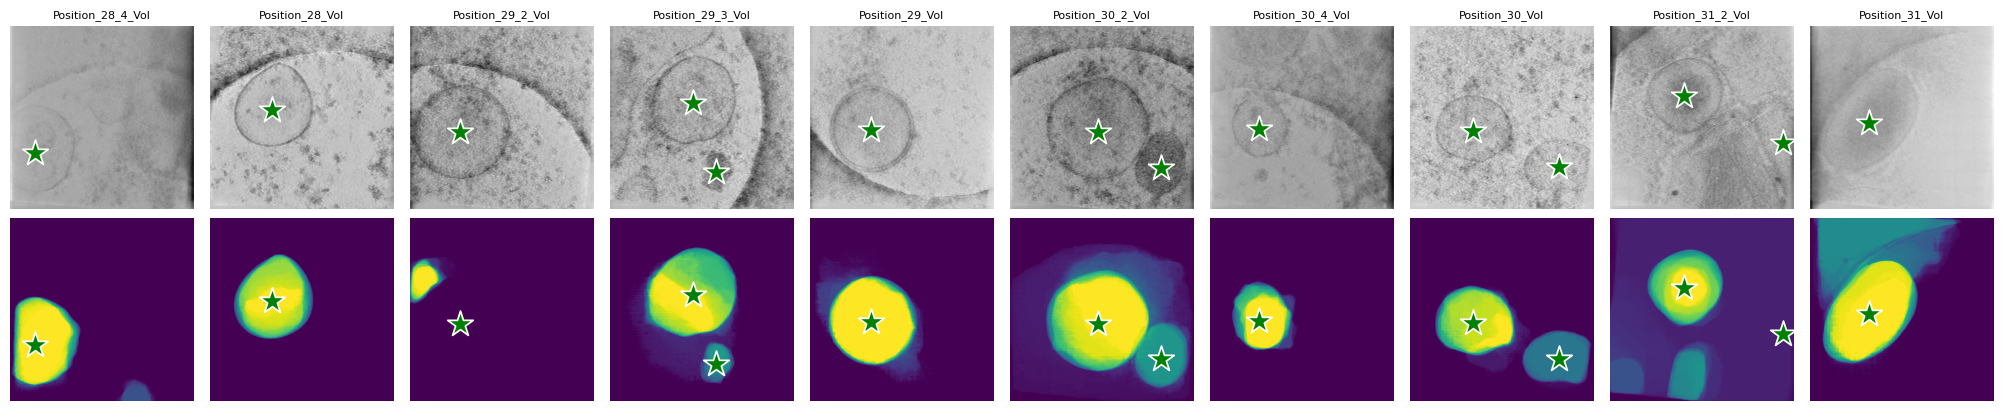

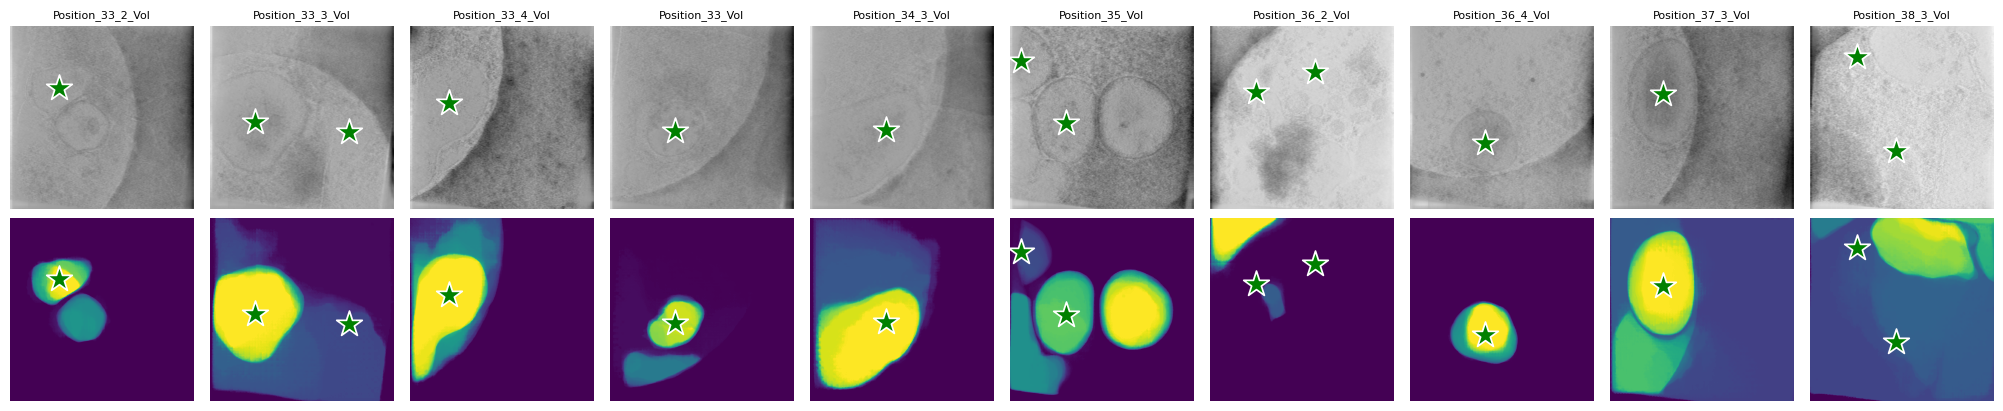

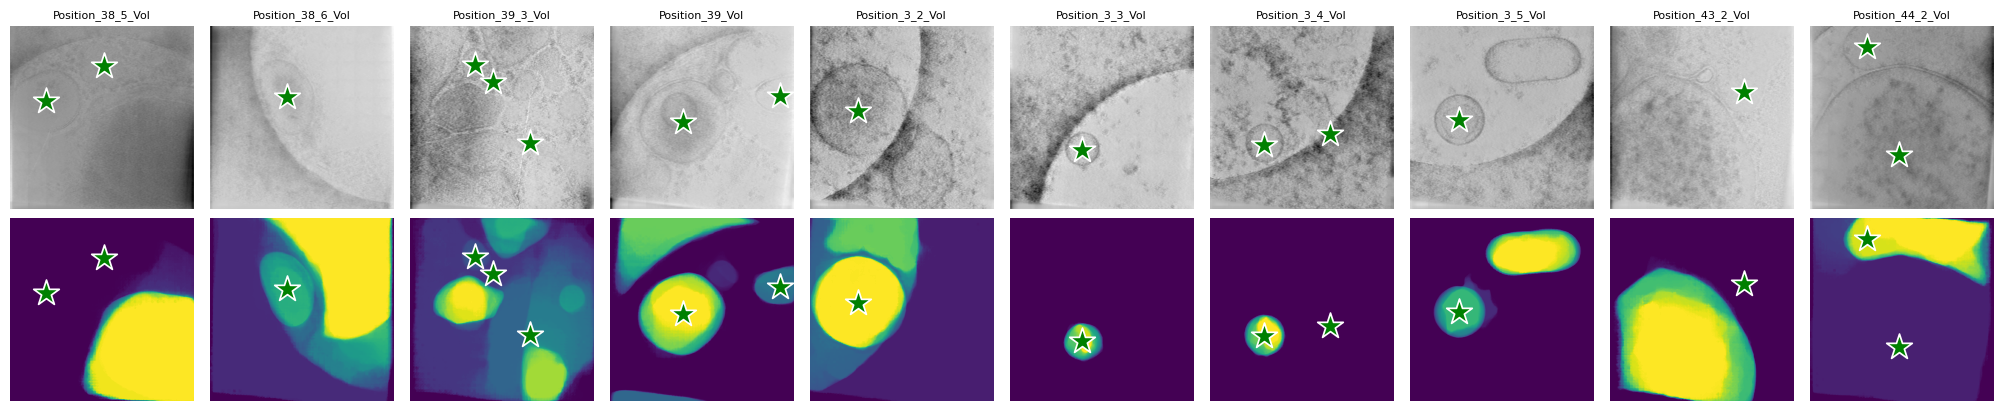

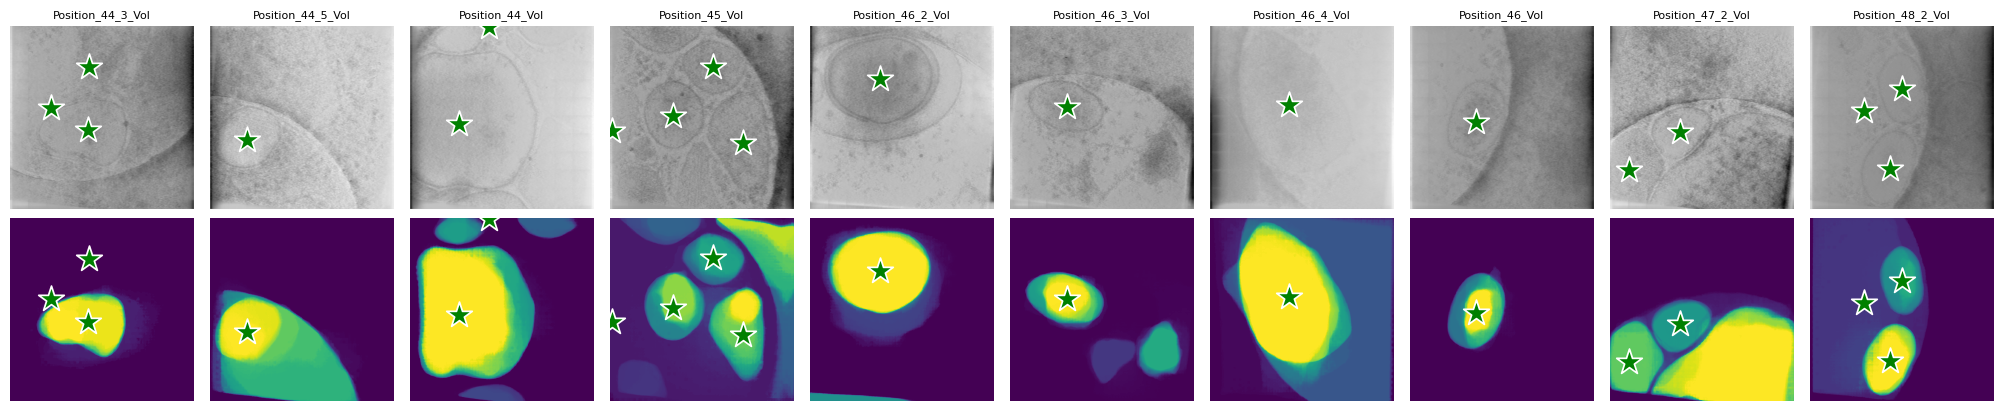

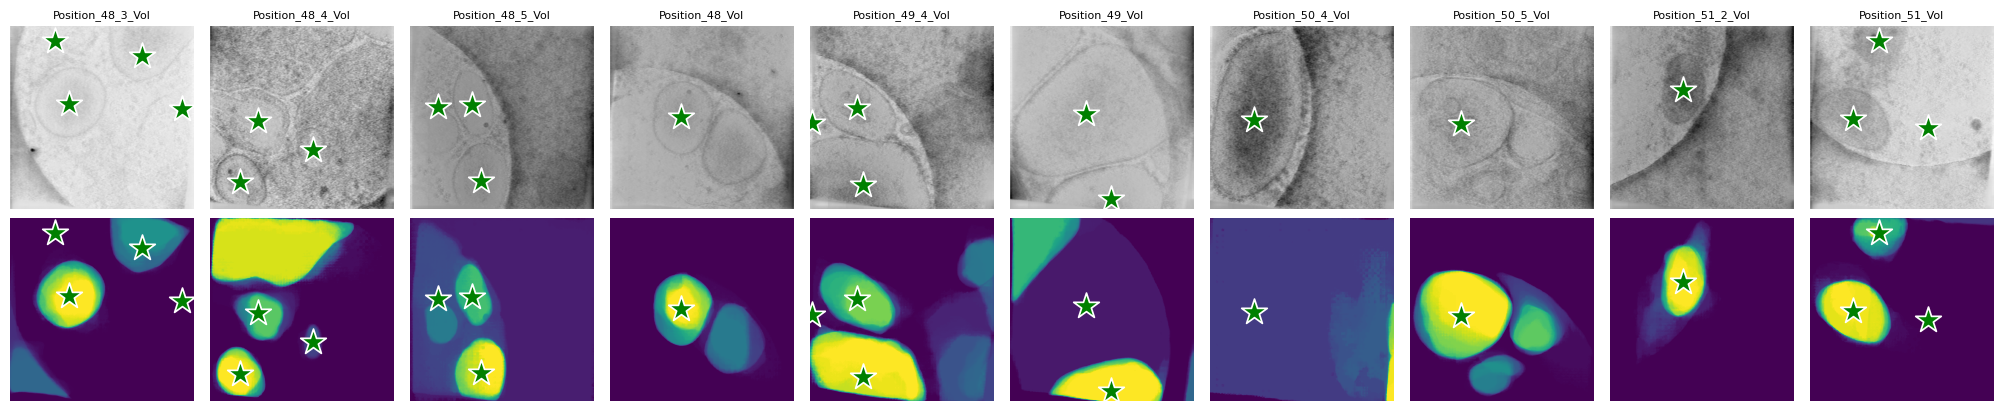

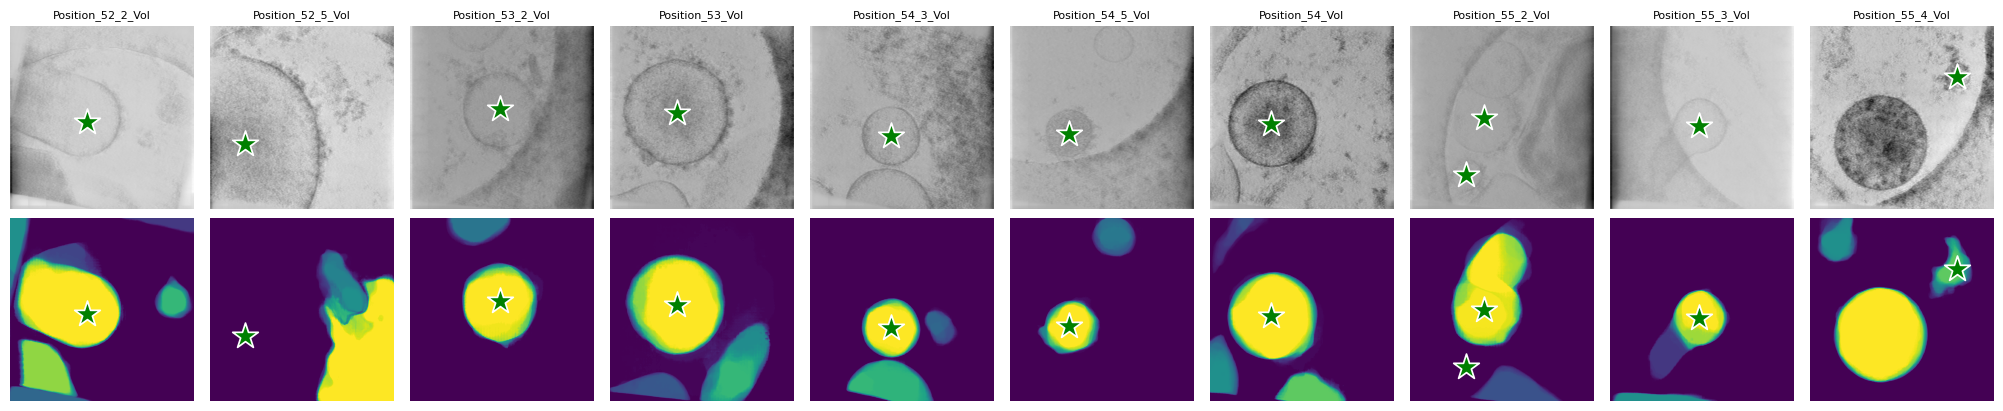

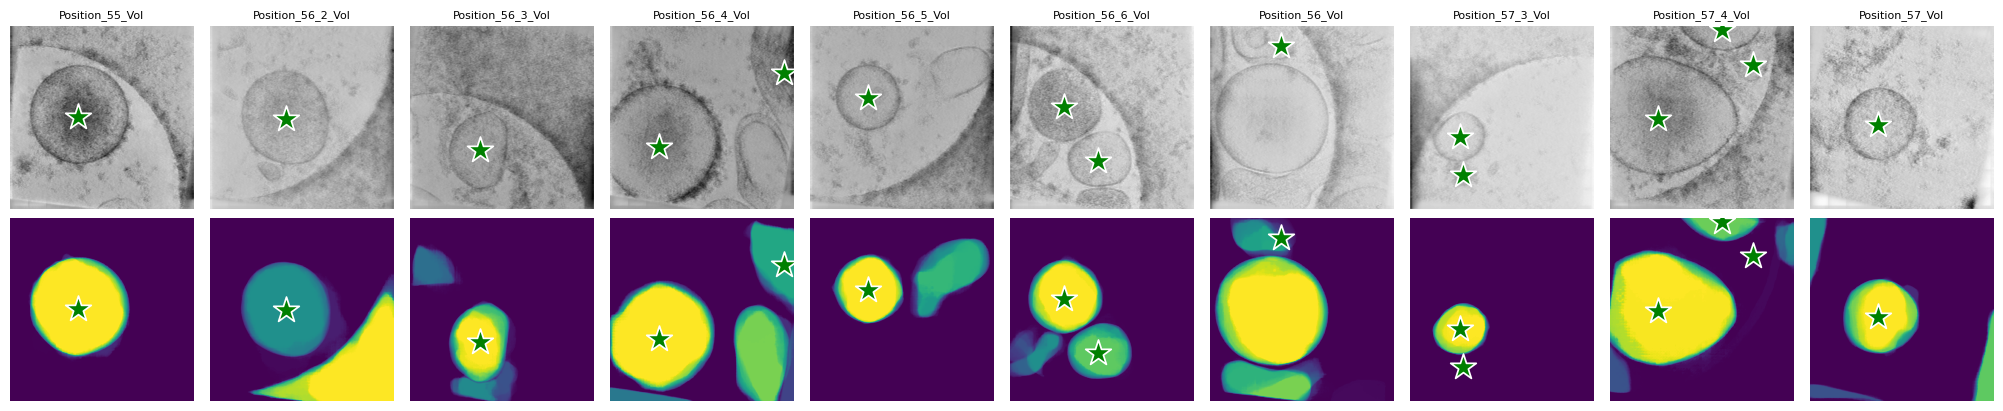

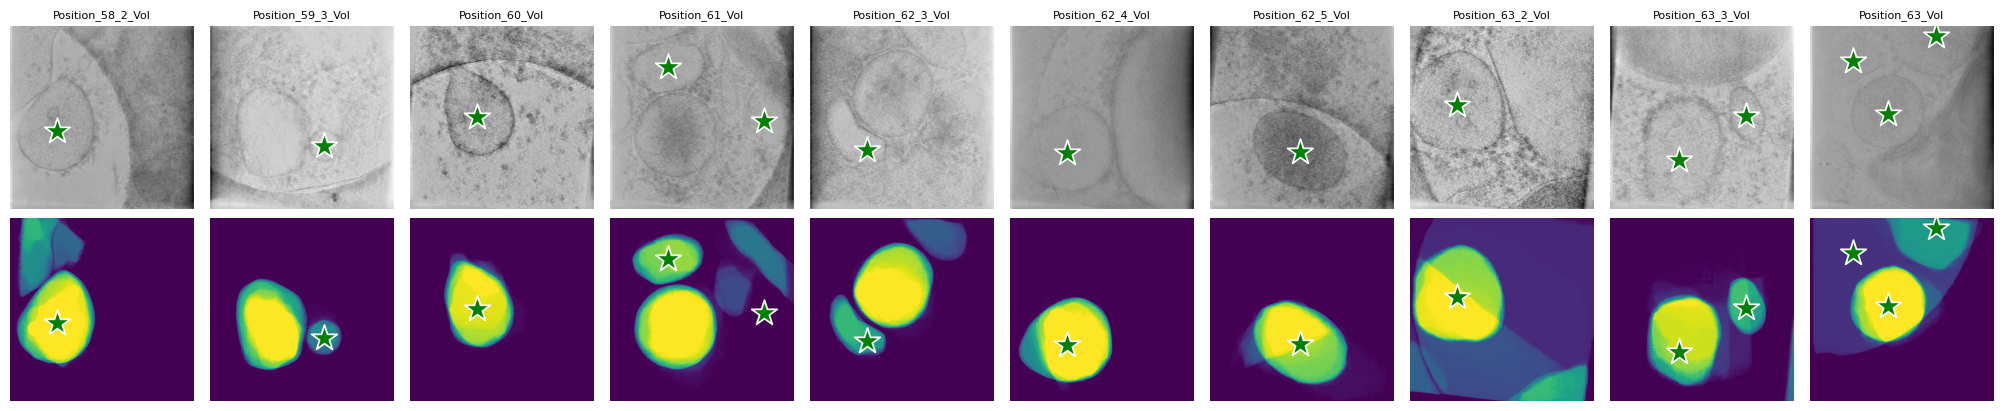

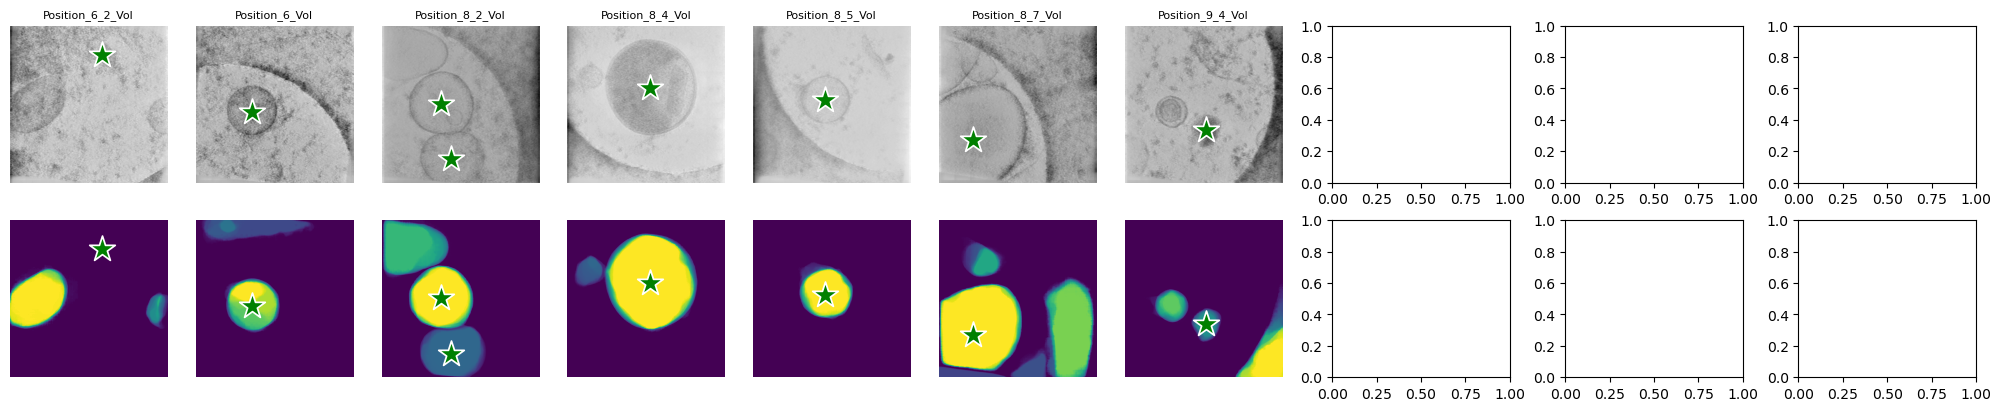

In [40]:
pw_rows = []
pw_new_col = []
fig = None
fig_col_count = 0
verbose = False

organelle_segs_all = []
no_organelles_all = []
no_cryosam = []
for run in runs_with_lysosomes:
    coords = coords_per_run[run.name]
    tomo = utils.get_tomogram(run, verbose=False)

    vol_mask_fname = Path(input_dir) / f"vol_mask_{run.name}.pkl"
    if vol_mask_fname.exists():
        vol_mask = joblib.load(vol_mask_fname)
    else:
        vol_mask = np.zeros(tomo.shape, dtype="uint8")
        continue

    vol_mask = joblib.load(vol_mask_fname)

    if fig is None:
        fig, axs = plt.subplots(2, 10, figsize=(20, 4), constrained_layout=True)
        axs = axs.ravel()
    axs[fig_col_count].imshow(tomo[25:-25].sum(axis=0), cmap="gray")
    # axs[fig_col_count].imshow(membrane.sum(axis=0), cmap="Reds", alpha=0.5)
    axs[fig_col_count].set_title(run.name, fontsize=8)
    axs[fig_col_count].axis("off")

    labels = np.ones(coords.shape[0])
    utils.show_points(coords[:, [2, 1]], labels, axs[fig_col_count])

    # color_projection = np.zeros_like(vol_mask[25:-25].sum(axis=0))
    # for _seg_id in range(1, vol_mask.max() + 1):
    #    _seg_mask = vol_mask[25:-25] == _seg_id
    #    _seg_mask = _seg_mask.sum(axis=0) > 0
    #    _seg_mask[_seg_mask] = np.random.randint(0, 255)

    cm = axs[fig_col_count + 10].imshow(vol_mask[25:-25].sum(axis=0))
    axs[fig_col_count + 10].axis("off")
    utils.show_points(coords[:, [2, 1]], labels, axs[fig_col_count + 10])
    # axs[fig_col_count + 10].set_title("No_org_seg", fontsize=8)
    # plt.colorbar(cm, ax=axs[fig_col_count + 10], fraction=0.046, pad=0.04)
    fig_col_count += 1
    if fig_col_count == 10:
        fig_col_count = 0
        plt.show()
        fig = None
    # raise